In [10]:
from skimage import io,filters, morphology, measure, draw,exposure
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import stats
import trackpy as tp
import pandas as pd
from scipy.stats import median_abs_deviation
from scipy.optimize import curve_fit
from sklearn.neighbors import KernelDensity
import seaborn as sns
from scipy.interpolate import make_interp_spline, BSpline
import imageio
from skimage.filters import threshold_otsu,threshold_multiotsu
from scipy.stats import ttest_ind,ttest_rel
import warnings
warnings.filterwarnings('ignore')

In [1]:
PATH = '</PATH/TO/DIR/WAVE/Beads_assay/'

In [2]:
def fill_multi_contours(cells_label_mask_clean, pad):
    num_cells = np.max(cells_label_mask_clean)
    output = np.zeros_like(cells_label_mask_clean)
    
    for target in range(1, num_cells+1):
        output += fill_contours((cells_label_mask_clean==target) * target, pad)
        
    return output

In [3]:
def fill_contours(cells_label_mask_clean, pad):
    return np.pad(np.maximum.accumulate(cells_label_mask_clean, 1),((0,0),(pad,0)), mode='constant')[:, :-pad] & \
           np.pad(np.maximum.accumulate(cells_label_mask_clean[:,::-1],1)[:,::-1],((0,0),(0,pad)), mode='constant')[:, pad:] & \
           np.pad(np.maximum.accumulate(cells_label_mask_clean, 0),((pad,0),(0,0)), mode='constant')[:-pad,:] & \
           np.pad(np.maximum.accumulate(cells_label_mask_clean[::-1,:],0)[::-1,:],((0,pad),(0,0)), mode='constant')[pad:,:]

In [4]:
def seg_cells(image, threshold, sigma,min_size, max_size, plot = True):
    """
    Segment out regions with a given fluorescence threshold in a cell
 
    Parameters
    ----------
    image : 2D array
        Raw tif image (single frame).
    threshold: float
        threshold used for segmentation
    sigma: float
        Standard deviation for Gaussian kernel.The larger the value, the smoothier the gaussian fitting.
    min_size: float
        minimum size of the segmented region
    max_size: float
        maximum size of the segmented region
    plot: bool
        whether or not plot the segmentation image
    
    Returns
    -------
    region_properties: list of RegionProperties
        Each item describes one labeled region with the corresponding attributes. 
    label_mask_clean:2D array 
        Segmentations based on fluorescent intensities of the image. 
        Each integer corresponds to a unique segmentation and 0 is the background.
        
    """
    smooth = filters.gaussian(image,sigma,preserve_range=True)
    cell_mask = smooth > threshold
    label_mask = measure.label(cell_mask)
    region_properties = measure.regionprops(label_mask)  
    label_mask_clean = label_mask.copy()
    for r in region_properties:
        if r.area <= min_size or r.area >= max_size:
            label_mask_clean[label_mask_clean == r.label] = 0
    if plot:
        plt.figure(figsize = (10,10))
        plt.imshow(image)
        plt.contour(label_mask_clean,colors = 'r',linewidths = 0.7)

    region_properties = measure.regionprops(label_mask_clean,intensity_image=image)
    return label_mask_clean,region_properties

In [5]:
def PeakWidth(data,rel_height):
    peaks, _ = find_peaks(data)
    print(rel_height)
    results = peak_widths(data, peaks, rel_height)
    plt.plot(data)
    plt.plot(peaks, data[peaks], "x")

    plt.hlines(*results[1:], color="C3")
    plt.show()
    return results

In [6]:
def find_max_integral(time, signal,spf):
    max_integral = 0
    max_t_start = -1
    max_t_end = -1
    new_sig = []
    for s in signal:
        if s<1:
            new_sig.append(0)
        else:
            new_sig.append(s-1)
    for start_idx in range(len(time)-1):
        start_t = time[start_idx]
        desired_end_t = start_t + 60//spf+1
        if desired_end_t > time[-1]:
            break
        try:
            end_idx = time.index(desired_end_t)
        except Exception:
#             print("time not found: ", desired_end_t)
            continue

        target_sig = new_sig[start_idx:end_idx]
        target_time = time[start_idx:end_idx]

        r = scipy.integrate.simps(np.array(target_sig),np.array(target_time)*spf)
        
        if r > max_integral:
            max_integral = r
            max_t_start = start_idx
            max_t_end = end_idx
    
    return max_integral,max_t_start,max_t_end

In [7]:
def get_top_twenty_index(cur):
    """
    Find out the window of length 20 that contains highest fluorescent signal
    """
    max_wave = 0
    for j in range(cur.frame.min(),cur.frame.max()-20):
        reg = cur[(cur.frame>=j) & (cur.frame <= j+20)]
        if reg.norm_wave.mean()> max_wave:
            max_wave = reg.norm_wave.mean()
            std_frame = reg.frame.min()
            end_frame = reg.frame.max()
    return max_wave,std_frame,end_frame
                

In [8]:
class Intensity_on_beads:
    def __init__(self, intensity, time):
        self.intensity = intensity
        self.time = time
    

# Extract WAVE complex and Membrane fluorescent intensities on beads

In [11]:
image = io.imread(PATH + 'example_images/cell14_240403_pmw7_200nm_tirf_016.tif')

In [12]:
spf = 3


In [13]:
image.shape

(90, 322, 319, 3)

In [14]:
beads = image[:,:,:,1]

In [15]:
mem= image[:,:,:,2]

In [16]:
cells = image[:,:,:,0]

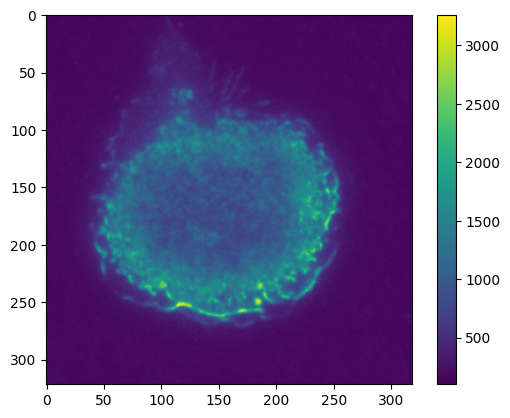

In [17]:
plt.imshow(cells[10])

plt.colorbar()

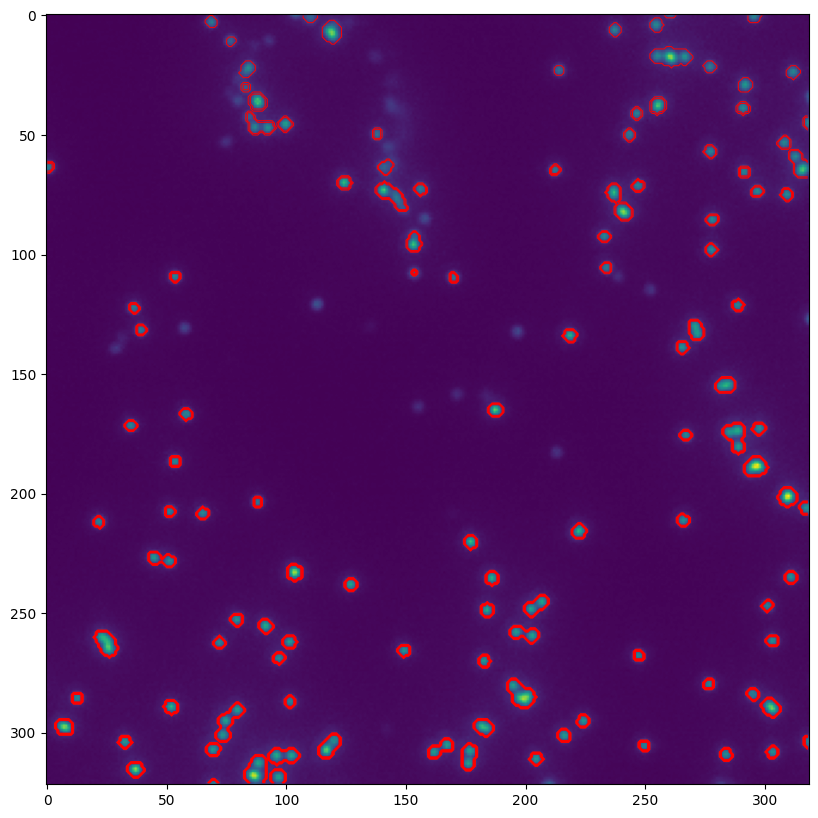

In [18]:
i = 0
label_mask_clean,beads_features= seg_cells(beads[i],threshold_otsu(beads[i]),1,3,100)

for r in beads_features:
    y_center, x_center = r.centroid # note that image coordinates are often given as (y, x) rather than (x, y)
#     ax.text(x_center, y_center, str(r.label), fontweight = 'bold', color = 'white')
plt.show()

[ 547 1228]


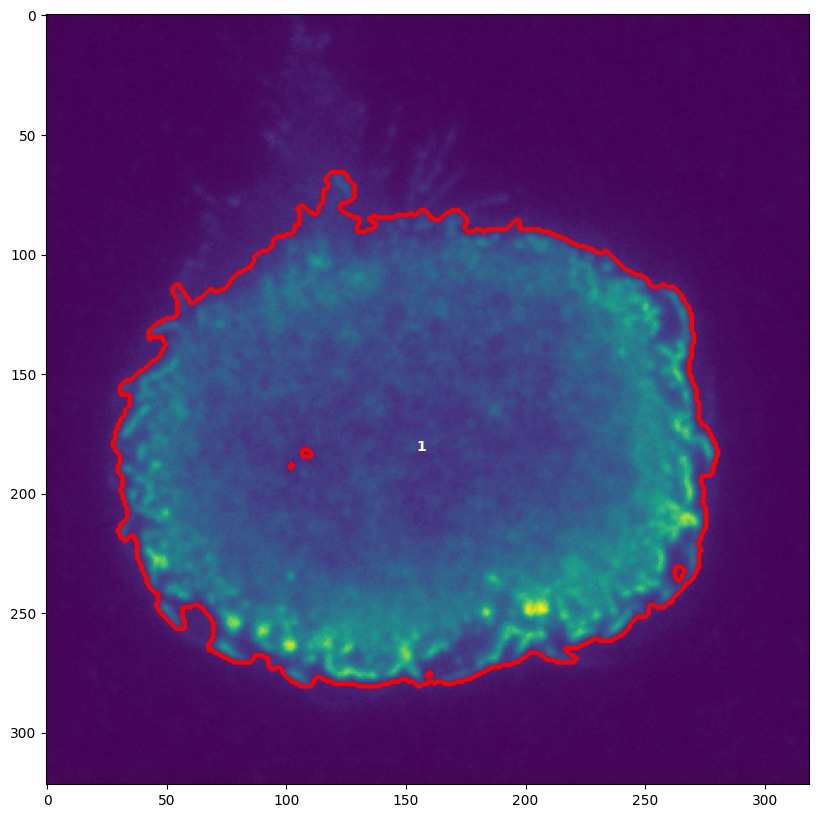

In [19]:
i = 20
print(threshold_multiotsu(cells[i]))
label_mask_clean,cells_features = seg_cells(cells[i],threshold_multiotsu(cells[i])[0],1,1000,2000000,False)
plt.figure(figsize = (10,10))  
ax = plt.subplot()
plt.imshow(cells[i])
plt.contour(label_mask_clean,colors = 'red')

for r in cells_features:
    y_center, x_center = r.centroid # note that image coordinates are often given as (y, x) rather than (x, y)
    ax.text(x_center, y_center, str(r.label), fontweight = 'bold', color = 'white')
plt.show()

In [20]:
features = pd.DataFrame()
for i in range(0,cells.shape[0]):
        beads_label_mask_clean,beads_features = seg_cells(beads[i],threshold_otsu(beads[i]),1,3,100,False)  
        cells_label_mask_clean,cells_features = seg_cells(cells[i],threshold_multiotsu(cells[i])[0],1,1000,10000000,False)
        # shrink the cell mask boundary to target for beads within the cells
        shrinked_cell_mask = fill_multi_contours(cells_label_mask_clean, 4)
        beads_left = shrinked_cell_mask*beads_label_mask_clean
        beads_properties = measure.regionprops(beads_left,intensity_image=cells[i])
        mem_properties = measure.regionprops(beads_left,intensity_image=mem[i])
        for j in range(len(beads_properties)):
            y = beads_properties[j].centroid[0]
            x = beads_properties[j].centroid[1]
            features = features.append([{'y': y,
                                         'x': x,
                                         'area':beads_properties[j].area,
                                         'bbox': beads_properties[j].bbox,
                                         'frame': i,
                                         'wave_intensity': beads_properties[j].intensity_mean,
                                         'perimeter':beads_properties[j].perimeter,
                                         'mem_intensity': mem_properties[j].intensity_mean},])


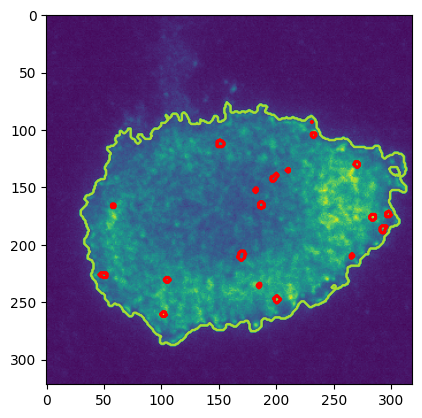

In [21]:
plt.contour(cells_label_mask_clean)
plt.contour(beads_left,colors = 'red')
plt.imshow(cells[-1])

In [22]:
t = tp.link_df(features,10, memory=3)

Frame 89: 19 trajectories present.


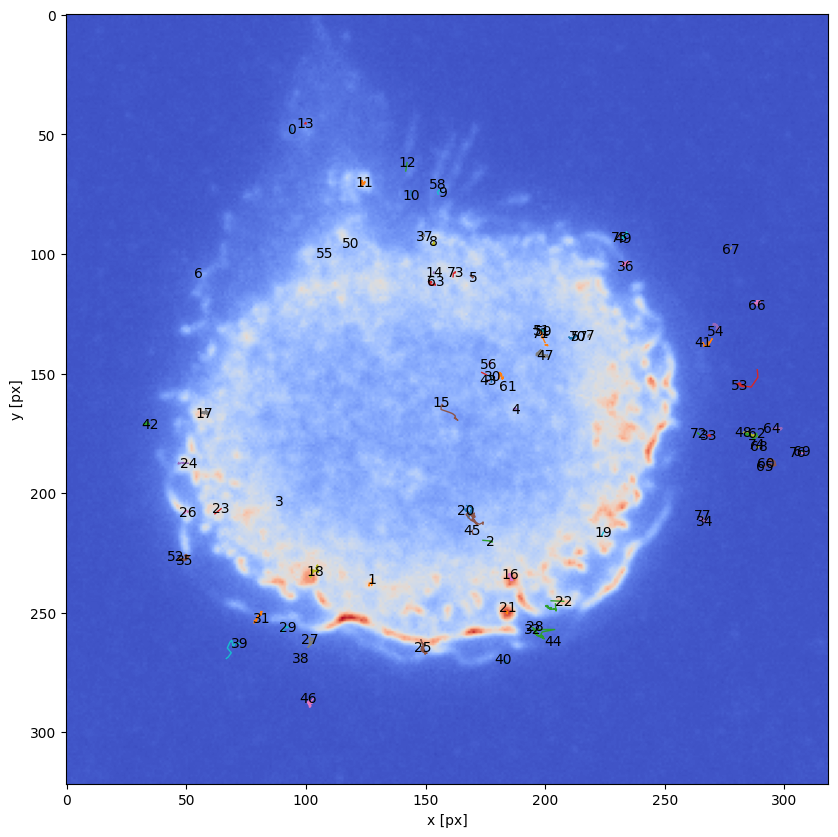

In [23]:
plt.figure(figsize=(10,10))
plt.imshow(cells[10],cmap = 'coolwarm')
# t_new = t[t.frame<10]
tp.plot_traj(t,label = True)
plt.show()

In [24]:
# Calculate the background for WAVE and membrane 
n = 1
# n += 1
wave_background = []
MEM_background = []
for i in np.unique(t.particle):
    particle = t[t.particle == i]
    for frame in particle.frame:
        bbox = particle[particle.frame ==frame].bbox[0]
        width = (bbox[2]-bbox[0]+bbox[3]-bbox[1])//2
        if bbox[0]>=width and bbox[2]+width<512 and bbox[1]-width>=0 and bbox[3]+width<512:
            cell_background = (cells[frame,bbox[0]-width:bbox[0],bbox[1]-width:bbox[3]+width].mean()\
                            +cells[frame,bbox[0]:bbox[2],bbox[1]-width:bbox[1]].mean()\
                            +cells[frame,bbox[0]:bbox[2],bbox[3]:bbox[3]+width].mean()\
                            +cells[frame,bbox[2]:bbox[2]+width,bbox[1]-width:bbox[3]+width].mean())/4
            mem_background = (mem[frame,bbox[0]-width:bbox[0],bbox[1]-width:bbox[3]+width].mean()\
                            +mem[frame,bbox[0]:bbox[2],bbox[1]-width:bbox[1]].mean()\
                            +mem[frame,bbox[0]:bbox[2],bbox[3]:bbox[3]+width].mean()\
                            +mem[frame,bbox[2]:bbox[2]+width,bbox[1]-width:bbox[3]+width].mean())/4
            wave_background.append(cell_background)
            MEM_background.append(mem_background)
        else:
            t = t[t.bbox !=bbox]
t['wave_background'] = wave_background
t['mem_background'] = MEM_background
t['cell'] = n

In [25]:
t['norm_wave'] = t['wave_intensity']/t['wave_background']
t['norm_mem'] = t['mem_intensity']/t['mem_background']

# Calculate and plot the mean WAVE vs. membrane intensity on beads

In [27]:
full_t = pd.read_csv(PATH + "csv_data/full_data.csv")

In [28]:
# Calculate the average of the top three WAVE complex intensity on each bead, 
# then calculate the average of wave/membrane intensity on beads in each cell.
result_wave = []
result_mem = []
for p in np.unique(full_t.cell):
    max_wave = []
    cor_mem= []
    t = full_t[full_t.cell == p]
    n = 0
    for i in np.unique(t.particle):
        cur = t[t.particle == i]
        if len(cur)>=10 and cur.norm_wave.max()>=3:
            n+=1
            ind = np.argpartition(cur.norm_wave, -3)[-3:]
            max_three = cur.iloc[ind,:]
            print(max_three)
            max_wave.append(max_three.norm_wave.mean())
            cor_mem.append(max_three.norm_mem.mean())
    print(n)
    result_wave.append(np.mean(max_wave))
    result_mem.append(np.mean(cor_mem))

      Unnamed: 0           y           x  area                  bbox  frame  \
1570           0  215.644068  307.254237    59  (211, 302, 221, 313)     22   
705            0  216.236364  308.218182    55  (212, 303, 221, 314)     10   
983            0  216.125000  307.910714    56  (212, 303, 222, 314)     14   

      wave_intensity  perimeter  mem_intensity  particle  wave_background  \
1570     1233.745763  30.970563    1272.372881         5       375.815625   
705      1448.600000  32.142136    1268.200000         5       411.622449   
983      1151.517857  32.384776    1260.535714         5       324.574747   

      mem_background  cell  norm_wave  norm_mem  
1570     1284.666667     1   3.282849  0.990430  
705      1572.224490     1   3.519244  0.806628  
983      1145.672121     1   3.547774  1.100259  
      Unnamed: 0           y           x  area                  bbox  frame  \
1138           0  266.068966  288.620690    29  (263, 286, 270, 292)     16   
2147           0

       Unnamed: 0           y      x  area                  bbox  frame  \
18073           0  261.200000  298.5    20  (259, 296, 264, 302)     43   
19597           0  261.291667  299.0    24  (259, 297, 265, 302)     56   
19923           0  261.560000  298.6    25  (259, 296, 265, 302)     59   

       wave_intensity  perimeter  mem_intensity  particle  wave_background  \
18073     1060.250000  14.485281       1415.150        14       364.568750   
19597     1087.833333  15.656854       1167.125        14       355.525641   
19923     1107.280000  15.899495       1458.640        14       313.478571   

       mem_background  cell  norm_wave  norm_mem  
18073      893.271875     4   2.908231  1.584232  
19597      841.221154     4   3.059789  1.387418  
19923     1428.438095     4   3.532235  1.021143  
       Unnamed: 0           y           x  area                  bbox  frame  \
14278           0  279.421053  215.368421    38  (277, 212, 283, 220)      7   
13830           0  279

       Unnamed: 0           y           x  area                  bbox  frame  \
32283           0  266.416667  266.791667    48  (263, 262, 271, 272)     40   
31601           0  266.520833  266.729167    48  (263, 262, 271, 272)     28   
32784           0  266.266667  267.044444    45  (262, 263, 271, 272)     49   

       wave_intensity  perimeter  mem_intensity  particle  wave_background  \
32283      799.958333  27.899495     796.333333         1       307.531481   
31601      932.520833  26.727922     805.479167         1       355.770833   
32784      836.022222  27.899495     958.288889         1       256.815051   

       mem_background  cell  norm_wave  norm_mem  
32283      533.968519     8   2.601224  1.491349  
31601      750.208333     8   2.621128  1.073674  
32784      437.742134     8   3.255347  2.189163  
       Unnamed: 0           y           x  area                  bbox  frame  \
32802           0  282.428571  186.904762    21  (280, 185, 286, 190)     50   
32

       Unnamed: 0           y           x  area                  bbox  frame  \
50978           0  351.142857  278.190476    21  (349, 276, 354, 281)     13   
51021           0  351.190476  278.857143    21  (349, 277, 354, 282)     15   
50876           0  351.200000  278.500000    20  (349, 276, 354, 282)      8   

       wave_intensity  perimeter  mem_intensity  particle  wave_background  \
50978     1529.047619  14.242641     621.761905         4       460.353333   
51021     1639.000000  14.242641     665.714286         4       426.350000   
50876     1809.800000  14.485281     624.950000         4       448.937500   

       mem_background  cell  norm_wave  norm_mem  
50978      512.900000    14   3.321465  1.212248  
51021      626.166667    14   3.844259  1.063158  
50876      623.138889    14   4.031296  1.002906  
       Unnamed: 0           y           x  area                  bbox  frame  \
50847           0  280.700000  375.066667    30  (278, 373, 285, 378)      6   
50

In [29]:
result = pd.DataFrame({'Membrane':result_mem,'WAVE complex':result_wave})

In [30]:
ttest_rel(result['Membrane'],result['WAVE complex'])[1]

6.322904517629102e-08

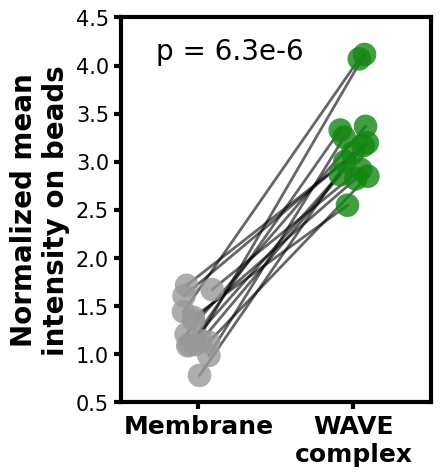

In [31]:
f, ax = plt.subplots(figsize =(4,5))
plt.ylim(0.5,4.5)
plt.ylabel('Normalized mean\nintensity on beads',size = 20,fontweight = 'bold')
plt.xticks(ticks = [0,1],labels = ['Membrane','WAVE\ncomplex'],size = 18,fontweight = 'bold')
plt.xlim(-0.4,1.4)
pal = ['#999999',"#138613"]
sns.stripplot(result,size =17, ax=ax,palette=pal,alpha = 0.8)

# Now connect the dots
# Find idx0 and idx1 by inspecting the elements return from ax.get_children()
# ... or find a way to automate it
idx0 = 0
idx1 = 1
locs1 = ax.get_children()[idx0].get_offsets()
locs2 = ax.get_children()[idx1].get_offsets()

set1 = result['Membrane']
set2 = result['WAVE complex']
# before plotting, we need to sort so that the data points
# correspond to each other as they did in "set1" and "set2"
sort_idxs1 = np.argsort(set1)
sort_idxs2 = np.argsort(set2)

# revert "ascending sort" through sort_idxs2.argsort(),
# and then sort into order corresponding with set1
locs2_sorted = locs2[sort_idxs2.argsort()][sort_idxs1]

for i in range(locs1.shape[0]):
    x = [locs1[i, 0], locs2_sorted[i, 0]]
    y = [locs1[i, 1], locs2_sorted[i, 1]]
    ax.plot(x, y, color="black", alpha=0.6,lw = 2)
y, h, col = 3, 0.3, 'k'
plt.text(0.2, 4, 'p = 6.3e-6', ha='center', va='bottom', color=col,size = 20)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)

# increase tick width
ax.tick_params(width=3,size =5)
plt.yticks(fontsize = 15)
plt.savefig(PATH + 'Fig5D_wave_vs_mem.png',dpi = 300,bbox_inches = 'tight')

# Plot WAVE and membrane signal on beads over time

In [33]:
# Select tracks for plotting 
wave_dynamics = pd.DataFrame()
mem_dynamics = pd.DataFrame()
for c in np.unique(full_t.cell):
    t = full_t[full_t.cell == c]
    for i in np.unique(t.particle):
        cur = t[t.particle == i]
        cur = cur.reset_index()
        if len(cur)>= 20 and cur.norm_wave.max()>=3 and cur.norm_wave.idxmax()>=2 and cur.norm_wave.idxmax()<=len(cur)-20:          
#             plt.plot(cur.frame,cur.norm_wave)
#             plt.plot(cur.frame,cur.norm_mem)
#             plt.show()
            max_wave,std,end = get_top_twenty_index(cur)
            print(max_wave,std-1,end-1)
            cur_r = cur[(cur.frame>=std-1) & (cur.frame<=end-1)]
            if len(cur_r) == 21:
                cur_r.frame = cur_r.frame-cur_r.frame.min()
                wave_dynamics[str(c)+'_'+str(i)] = cur_r.norm_wave.values
                mem_dynamics[str(c)+'_'+str(i)] = cur_r.norm_mem.values

2.4711259174082096 4 24
2.71853850418884 10 30
3.0044853920025822 9 29
2.3354605877355716 2 22
2.116953217376382 10 30
2.473491813631383 34 54
1.7084662789113922 8 28
1.2119293173766692 9 29
2.148495197001147 19 39
1.9336353216871767 19 39
1.5372394136749032 0 20
1.6415164857033713 35 55
2.042857698616625 14 34
1.6946277005945842 11 31
1.935178546753646 12 32
1.5952322922719706 16 36
1.6690796335043976 35 55
1.8988341353010423 16 36
1.8224630197368588 16 36
1.7547101719446907 34 54
1.50512539064396 35 54
2.5912857994764043 3 23
1.857853718707856 -1 19
1.9402858976754733 6 26
2.189383533451987 5 25
1.7075369441803416 0 20
2.275901559778865 4 23
2.185279784732484 14 34
1.844261589894181 4 24
2.4189884904903103 8 28
2.392851490572288 5 25
1.751574541683723 7 27
1.5528280292790686 5 25
2.1847410823400226 12 32
2.1690503902404297 14 34
2.371294374382912 8 27
2.153348327213368 17 37
2.281820031888581 19 39
2.0574331859554564 -1 19
1.8320548387592313 -1 19
2.1118076940029407 0 20
1.9831774050

In [34]:
mem_dynamics.to_csv(PATH + 'csv_data/mem_dynamics.csv')

In [35]:
wave_dynamics.to_csv(PATH + 'csv_data/wave_dynamics.csv')

In [36]:
wave_dynamics = pd.read_csv(PATH + 'csv_data/wave_dynamics.csv',index_col = 0)
mem_dynamics = pd.read_csv(PATH + 'csv_data/mem_dynamics.csv',index_col = 0)

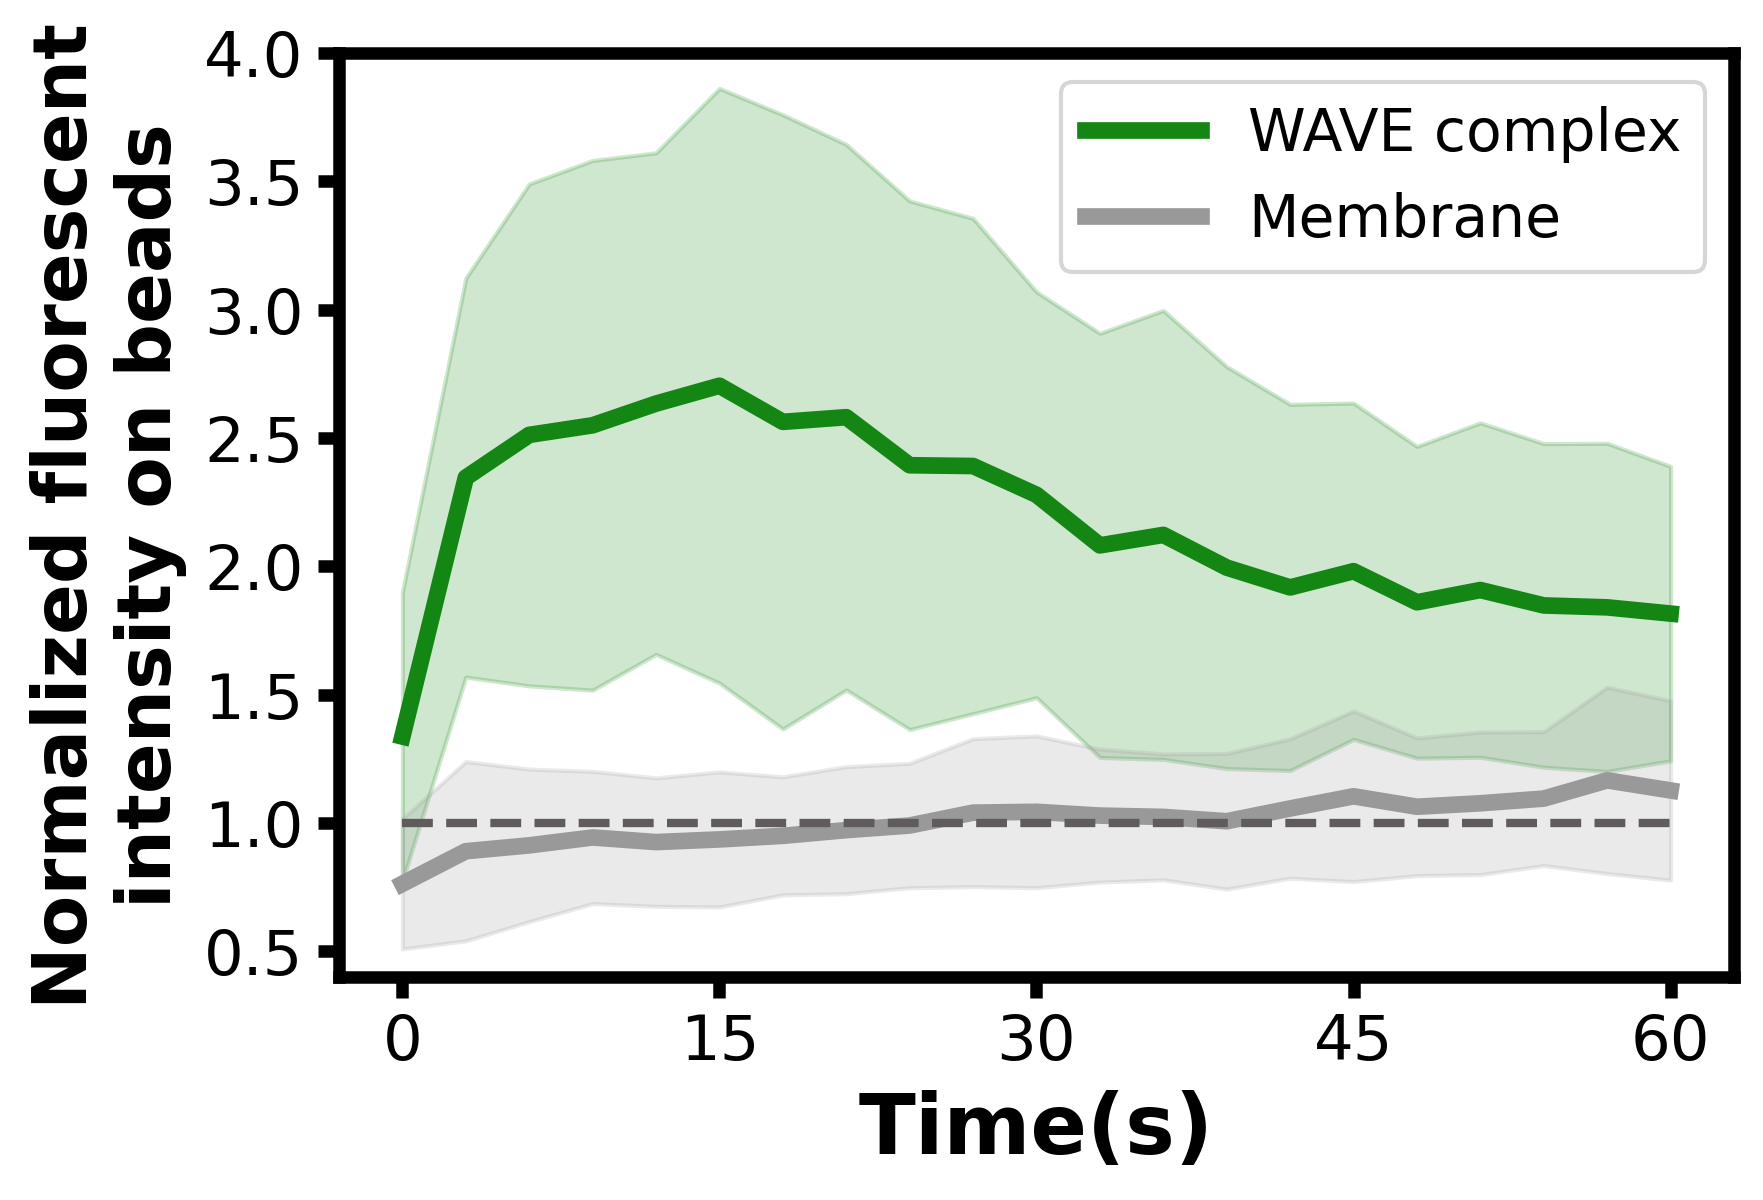

In [37]:
_,ax = plt.subplots(figsize = (6,4),dpi = 300)
ave = wave_dynamics.mean(axis = 1)
std = wave_dynamics.std(axis = 1)
plt.plot(np.arange(0,21),ave,lw = 4,c = '#138613',label = 'WAVE complex')
plt.fill_between(np.arange(0,21),ave-std,ave+std,alpha = 0.2,color = '#138613')
ave = mem_dynamics.mean(axis = 1)
std = mem_dynamics.std(axis = 1)
plt.plot(np.arange(0,21),ave,lw = 4,c = '#999999',label = 'Membrane')
plt.fill_between(np.arange(0,21),ave-std,ave+std,alpha = 0.2,color = '#999999')
plt.hlines(1,0,20,color = '#605c5c',ls = '--',lw = 2)
plt.ylim(0.4,4)
plt.xticks(np.arange(0,21,5),np.arange(0,61,15),size = 15)
plt.yticks(size =15)
plt.xlabel('Time(s)',size = 20,fontweight = 'bold')
plt.legend(fontsize = 14)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)

# increase tick width
ax.tick_params(width=3,size = 5)
plt.ylabel('Normalized fluorescent\nintensity on beads',size = 18,fontweight = 'bold')
plt.savefig(PATH + 'Fig5E_wave_dynamics.png',dpi = 300,bbox_inches = 'tight')

# Generate kymograph

In [43]:
kymo = io.imread(PATH + "example_images/kymograph of 221102_200nm_3s_7_crop.tif")

In [44]:
kymo.shape

(90, 38, 3)

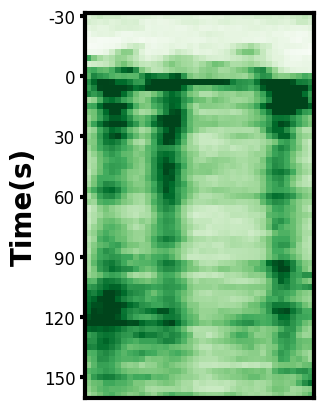

In [45]:
_,ax = plt.subplots(figsize = (8,5))
plt.imshow(kymo[0:64,:,2],cmap = "Greens",vmax = 1200)
plt.yticks(ticks = [0,10,20,30,40,50,60],labels = [-30,0,30,60,90,120,150],size = 12)
plt.ylabel('Time(s)',size = 20,fontweight = 'bold')
plt.xticks([])
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
# plt.xlabel('Distance (pixel)', size = 15)
# increase tick width
ax.tick_params(width=3)
plt.savefig(PATH + 'FigS4B_kymograph_wave.png',dpi = 300,bbox_inches= 'tight')